# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:08<00:00, 7.41KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

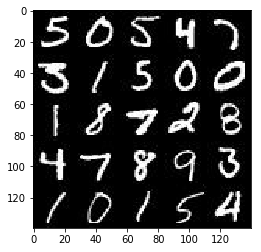

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

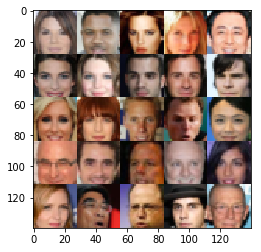

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_x = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, shape=[None, z_dim])
    lr = tf.placeholder(tf.float32)

    return real_x, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
import numpy as np

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        relu1 = tf.nn.relu(x1)
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=reuse)
        relu2 = tf.maximum(0.9 * bn2, bn2)
        
        flatten = tf.contrib.layers.flatten(relu1)
        logits = tf.layers.dense(flatten, 1)
        output = tf.nn.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*out_channel_dim)
        x1 = tf.reshape(x1, shape=(-1, 7, 7, out_channel_dim))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.9 * x1, x1)
        # 7x7xout_channel_dim now
        
        x2 = tf.layers.conv2d_transpose(x1, 16, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.9 * x2, x2)
        # 14x14xout_channel_dim now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, kernel_size=5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_real_model, d_real_logits = discriminator(input_real, reuse=False)
    d_fake_model, d_fake_logits = discriminator(g_model, reuse=True)
    
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake_model), 
                                                                         logits=d_fake_logits))
    
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_real_model), 
                                                                         logits=d_real_logits))
    
    d_loss = d_real_loss + d_fake_loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_fake_model), 
                                                                    logits=d_fake_logits))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    image_height = data_shape[-3]
    image_width = data_shape[-2]
    image_channels = data_shape[-1]

    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 10, input_z, image_channels, data_image_mode)
        show_generator_output(sess, 10, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1677... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 0.9541
Epoch 1/2... Discriminator Loss: 0.7663... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 0.6386... Generator Loss: 1.0904
Epoch 1/2... Discriminator Loss: 0.5660... Generator Loss: 1.1373
Epoch 1/2... Discriminator Loss: 0.5254... Generator Loss: 1.1726
Epoch 1/2... Discriminator Loss: 0.5014... Generator Loss: 1.1872
Epoch 1/2... Discriminator Loss: 0.4802... Generator Loss: 1.2084
Epoch 1/2... Discriminator Loss: 0.4684... Generator Loss: 1.2273
Epoch 1/2... Discriminator Loss: 0.4574... Generator Loss: 1.2673


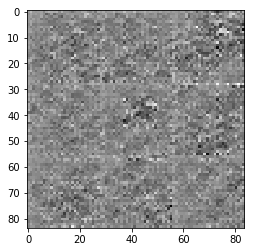

Epoch 1/2... Discriminator Loss: 0.4183... Generator Loss: 1.3684
Epoch 1/2... Discriminator Loss: 0.3824... Generator Loss: 1.4678
Epoch 1/2... Discriminator Loss: 0.3632... Generator Loss: 1.5586
Epoch 1/2... Discriminator Loss: 0.3290... Generator Loss: 1.6996
Epoch 1/2... Discriminator Loss: 0.2786... Generator Loss: 1.8769
Epoch 1/2... Discriminator Loss: 0.2641... Generator Loss: 1.9941
Epoch 1/2... Discriminator Loss: 0.2621... Generator Loss: 2.1214
Epoch 1/2... Discriminator Loss: 0.2726... Generator Loss: 2.2586
Epoch 1/2... Discriminator Loss: 0.2777... Generator Loss: 2.2905
Epoch 1/2... Discriminator Loss: 0.3230... Generator Loss: 2.5240


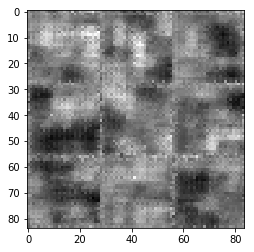

Epoch 1/2... Discriminator Loss: 0.3347... Generator Loss: 2.5268
Epoch 1/2... Discriminator Loss: 0.3550... Generator Loss: 2.5773
Epoch 1/2... Discriminator Loss: 0.3995... Generator Loss: 2.6736
Epoch 1/2... Discriminator Loss: 0.3311... Generator Loss: 2.6747
Epoch 1/2... Discriminator Loss: 0.3851... Generator Loss: 2.4273
Epoch 1/2... Discriminator Loss: 0.4148... Generator Loss: 2.5676
Epoch 1/2... Discriminator Loss: 0.3447... Generator Loss: 2.7322
Epoch 1/2... Discriminator Loss: 0.4265... Generator Loss: 2.5101
Epoch 1/2... Discriminator Loss: 0.3877... Generator Loss: 2.5413
Epoch 1/2... Discriminator Loss: 0.4245... Generator Loss: 2.4423


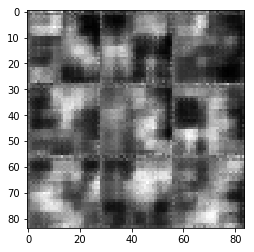

Epoch 1/2... Discriminator Loss: 0.4356... Generator Loss: 2.4356
Epoch 1/2... Discriminator Loss: 0.4708... Generator Loss: 2.2791
Epoch 1/2... Discriminator Loss: 0.4381... Generator Loss: 2.2696
Epoch 1/2... Discriminator Loss: 0.5135... Generator Loss: 2.2696
Epoch 1/2... Discriminator Loss: 0.4613... Generator Loss: 2.1768
Epoch 1/2... Discriminator Loss: 0.5980... Generator Loss: 2.0043
Epoch 1/2... Discriminator Loss: 0.5456... Generator Loss: 1.9897
Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 1.9466
Epoch 1/2... Discriminator Loss: 0.5480... Generator Loss: 1.9602
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 1.7370


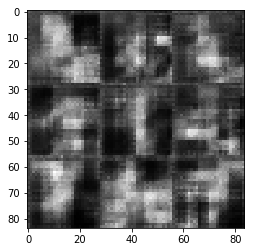

Epoch 1/2... Discriminator Loss: 0.5779... Generator Loss: 1.8897
Epoch 1/2... Discriminator Loss: 0.6178... Generator Loss: 1.7470
Epoch 1/2... Discriminator Loss: 0.6238... Generator Loss: 1.7590
Epoch 1/2... Discriminator Loss: 0.7116... Generator Loss: 1.6645
Epoch 1/2... Discriminator Loss: 0.6737... Generator Loss: 1.7213
Epoch 1/2... Discriminator Loss: 0.5975... Generator Loss: 1.8303
Epoch 2/2... Discriminator Loss: 0.6344... Generator Loss: 1.7595
Epoch 2/2... Discriminator Loss: 0.6615... Generator Loss: 1.7111
Epoch 2/2... Discriminator Loss: 0.6290... Generator Loss: 1.7637
Epoch 2/2... Discriminator Loss: 0.6042... Generator Loss: 1.7439


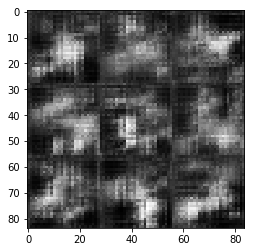

Epoch 2/2... Discriminator Loss: 0.5471... Generator Loss: 1.9026
Epoch 2/2... Discriminator Loss: 0.5409... Generator Loss: 1.8395
Epoch 2/2... Discriminator Loss: 0.4985... Generator Loss: 2.0069
Epoch 2/2... Discriminator Loss: 0.5412... Generator Loss: 1.8793
Epoch 2/2... Discriminator Loss: 0.4769... Generator Loss: 1.9944
Epoch 2/2... Discriminator Loss: 0.5113... Generator Loss: 1.9711
Epoch 2/2... Discriminator Loss: 0.5476... Generator Loss: 1.9377
Epoch 2/2... Discriminator Loss: 0.5133... Generator Loss: 1.9300
Epoch 2/2... Discriminator Loss: 0.4941... Generator Loss: 2.0486
Epoch 2/2... Discriminator Loss: 0.4462... Generator Loss: 2.0367


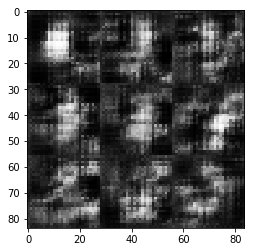

Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 2.0659
Epoch 2/2... Discriminator Loss: 0.5084... Generator Loss: 2.0293
Epoch 2/2... Discriminator Loss: 0.4381... Generator Loss: 2.1166
Epoch 2/2... Discriminator Loss: 0.4991... Generator Loss: 2.0605
Epoch 2/2... Discriminator Loss: 0.4844... Generator Loss: 2.0749
Epoch 2/2... Discriminator Loss: 0.3895... Generator Loss: 2.2452
Epoch 2/2... Discriminator Loss: 0.4584... Generator Loss: 2.0900
Epoch 2/2... Discriminator Loss: 0.4451... Generator Loss: 2.0731
Epoch 2/2... Discriminator Loss: 0.4774... Generator Loss: 2.2021
Epoch 2/2... Discriminator Loss: 0.4365... Generator Loss: 2.3355


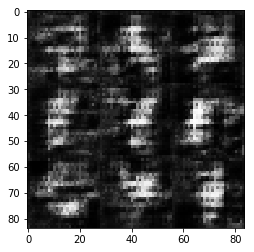

Epoch 2/2... Discriminator Loss: 0.4157... Generator Loss: 2.3332
Epoch 2/2... Discriminator Loss: 0.4991... Generator Loss: 2.3116
Epoch 2/2... Discriminator Loss: 0.4313... Generator Loss: 2.2895
Epoch 2/2... Discriminator Loss: 0.3718... Generator Loss: 2.4330
Epoch 2/2... Discriminator Loss: 0.3791... Generator Loss: 2.4292
Epoch 2/2... Discriminator Loss: 0.3772... Generator Loss: 2.4040
Epoch 2/2... Discriminator Loss: 0.4114... Generator Loss: 2.4235
Epoch 2/2... Discriminator Loss: 0.3468... Generator Loss: 2.6823
Epoch 2/2... Discriminator Loss: 0.3664... Generator Loss: 2.6337
Epoch 2/2... Discriminator Loss: 0.3433... Generator Loss: 2.6895


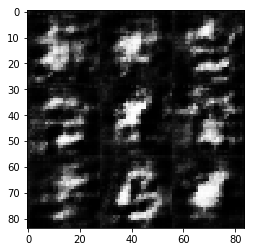

Epoch 2/2... Discriminator Loss: 0.3210... Generator Loss: 2.6478
Epoch 2/2... Discriminator Loss: 0.2833... Generator Loss: 2.6863
Epoch 2/2... Discriminator Loss: 0.2838... Generator Loss: 2.7690
Epoch 2/2... Discriminator Loss: 0.2544... Generator Loss: 2.9241
Epoch 2/2... Discriminator Loss: 0.2682... Generator Loss: 2.8998
Epoch 2/2... Discriminator Loss: 0.2660... Generator Loss: 2.8452
Epoch 2/2... Discriminator Loss: 0.2253... Generator Loss: 3.1380
Epoch 2/2... Discriminator Loss: 0.2297... Generator Loss: 2.9970
Epoch 2/2... Discriminator Loss: 0.2122... Generator Loss: 3.0250
Epoch 2/2... Discriminator Loss: 0.1704... Generator Loss: 3.1969


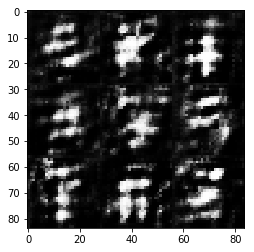

Epoch 2/2... Discriminator Loss: 0.1689... Generator Loss: 3.3342
Epoch 2/2... Discriminator Loss: 0.1414... Generator Loss: 3.3425
Epoch 2/2... Discriminator Loss: 0.1596... Generator Loss: 3.2634


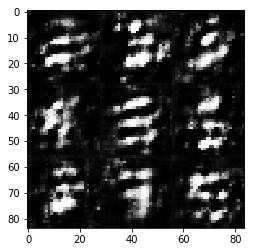

In [19]:
batch_size = 128
z_dim = 300#100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.1497
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 1.5242
Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 1.6509
Epoch 1/1... Discriminator Loss: 0.3779... Generator Loss: 1.7474
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 1.8216
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 1.8319
Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 1.8734


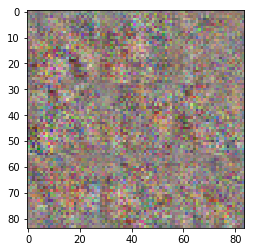

Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 1.8485
Epoch 1/1... Discriminator Loss: 0.4441... Generator Loss: 1.8843
Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 1.7948
Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 1.8183
Epoch 1/1... Discriminator Loss: 0.5435... Generator Loss: 1.6859
Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 1.6352
Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 1.7134
Epoch 1/1... Discriminator Loss: 0.6145... Generator Loss: 1.6189
Epoch 1/1... Discriminator Loss: 0.6228... Generator Loss: 1.6250
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 1.7467


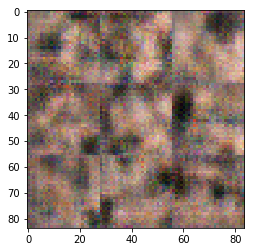

Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 1.6965
Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 1.6421
Epoch 1/1... Discriminator Loss: 0.5657... Generator Loss: 1.6645
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 1.5830
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 1.5534
Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 1.5149
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 1.5077
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.4262
Epoch 1/1... Discriminator Loss: 0.6531... Generator Loss: 1.3664
Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 1.3430


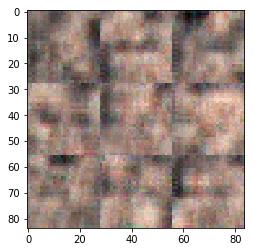

Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 1.3600
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 1.3609
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 1.2936
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.3755
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.3738
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.3798
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.3493


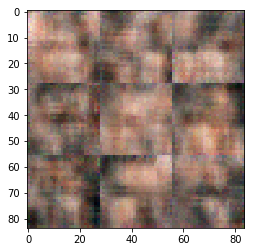

Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.4819
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.3740
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.4012
Epoch 1/1... Discriminator Loss: 0.6259... Generator Loss: 1.4539
Epoch 1/1... Discriminator Loss: 0.6247... Generator Loss: 1.5206
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 1.3642
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 1.4277


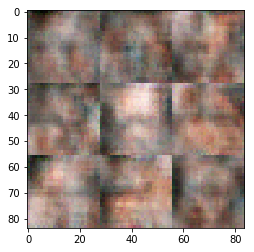

Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.3123
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 1.3828
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.3805
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.3964
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 1.4493
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.3070
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.3663
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.2537


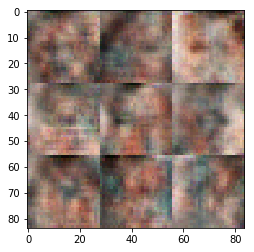

Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.1771
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.2288
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.2827
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.2171


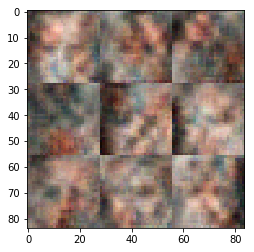

Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 1.1552
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.0844
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.0615


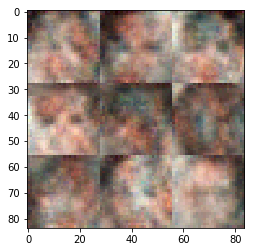

Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.0442


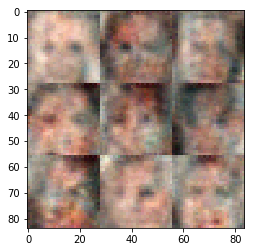

Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.9705


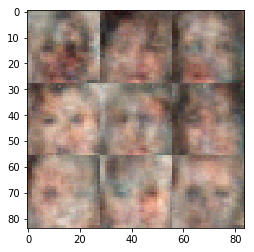

Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 0.9804
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 0.9954


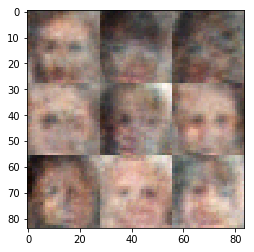

Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.9411


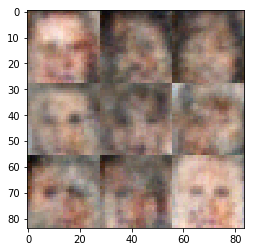

Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.9647


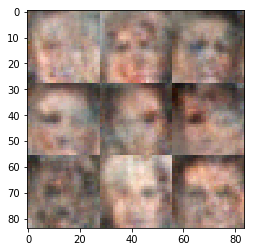

Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 0.9600


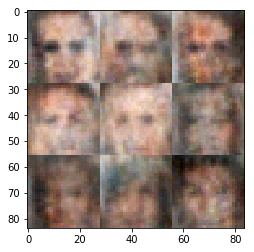

Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.9064


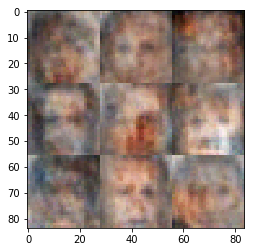

Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.9462


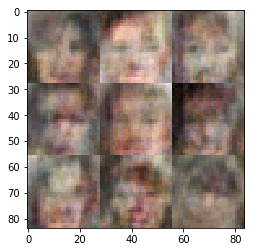

In [20]:
batch_size = 128
z_dim = 300#100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.